## ** Algo Name : Breast cancer prediction and segmentation .......  **
..
# Algo techStack : Deep Learning (CNN)
# Algo Architecture used : U-Net & Base CNN
# GPU Used : yes 
# processing type : Parallel with two model
# Model extention : Keras format
## framework used : Tenserflow 2.3

## Algo Creater : Shoeb Ahmad (shoeb.ahmad@bridgei2i.com , er.shoaib10@gmail.com ..

**Drive and path management**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [2]:
path = r'/content/drive/My Drive/Colab Notebooks/Breast_cancer/Dataset_BUSI_with_GT/'

In [3]:
%cd '/content/drive/My Drive/Colab Notebooks/Breast_cancer/Dataset_BUSI_with_GT/'

/content/drive/My Drive/Colab Notebooks/Breast_cancer/Dataset_BUSI_with_GT


**Unzip Operation**

In [4]:
#!unzip 'archive (1).zip' -d path

**Packages Used and Visualization tools**

In [12]:
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Flatten, LeakyReLU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow import squeeze
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from numpy.random import randint
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
!nvidia-smi

Thu Aug 26 08:41:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**#Helper function to get the index for real image and mask.**

In [ ]:

def num (image) :
    
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

**#Initialize the arrays for benign, normal and malignant tumors, both real and mask. 
As already given the number of samples in benign, normal & malignant are 437, 133 and 210 respectively.**

In [ ]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m = np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [67]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

**Visualization plot for getting data mask mapping**

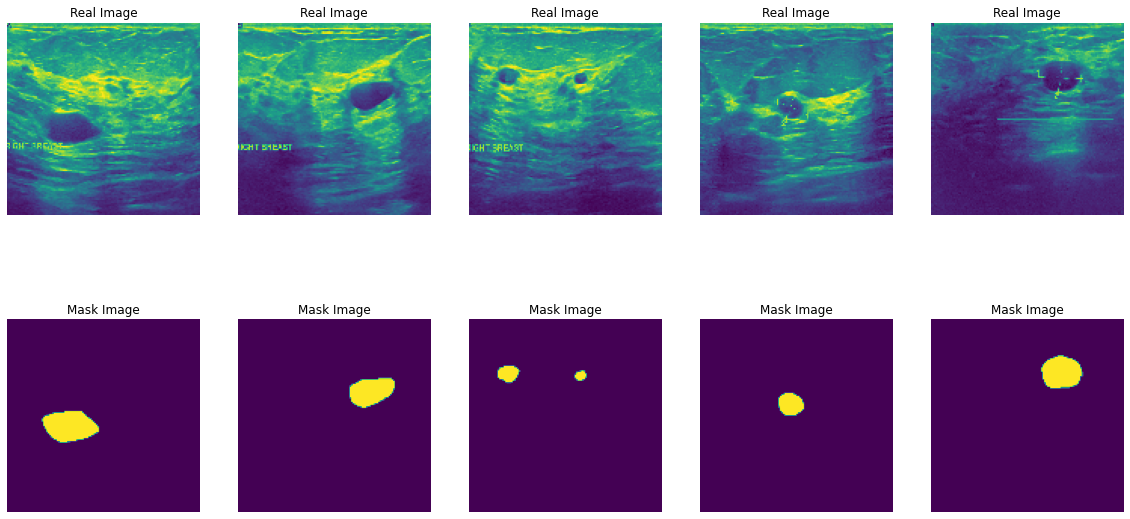

In [ ]:
#Visualize the results to verify the above method
import tensorflow as tf
plt.figure(figsize = (20,10))

for i in range(5) :
    plt.subplot(2,5,i+1)
    plt.imshow(tf.squeeze(X_b[i+1]))
    plt.title('Real Image')
    plt.axis('off')

for i in range(5) :
    plt.subplot(2,5,i+6)
    plt.imshow(tf.squeeze(y_b[i+1]))
    plt.title('Mask Image')
    plt.axis('off')
plt.show()

**Data Shapes and concetination**

In [ ]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)
X /= 255.0
y /= 255.0
print(X.shape)
print(y.shape)
print(X.max())
print(X.min())
print(y.max())
print(y.min())
y[y > 1.0] = 1.0
print(y.max())
print(y.min())

(780, 128, 128, 1)
(780, 128, 128, 1)
1.0
0.0
2.0
0.0


In [47]:
plt.figure(figsize = (10,30))
i = 0
while i < 16 :
    
    x = np.random.randint(0,780)
    
    plt.subplot(8,2,i+1)
    plt.imshow(tf.squeeze(X[x]))
    plt.title('Real Image')
    plt.axis('off')
    
    plt.subplot(8,2,i+2)
    plt.imshow(tf.squeeze(y[x]))
    plt.title('Mask Image')
    plt.axis('off')
    
    i += 2
plt.show()

**Data is devided into test train split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(741, 128, 128, 1)
(741, 128, 128, 1)
(39, 128, 128, 1)
(39, 128, 128, 1)


**U-Net Implementation**

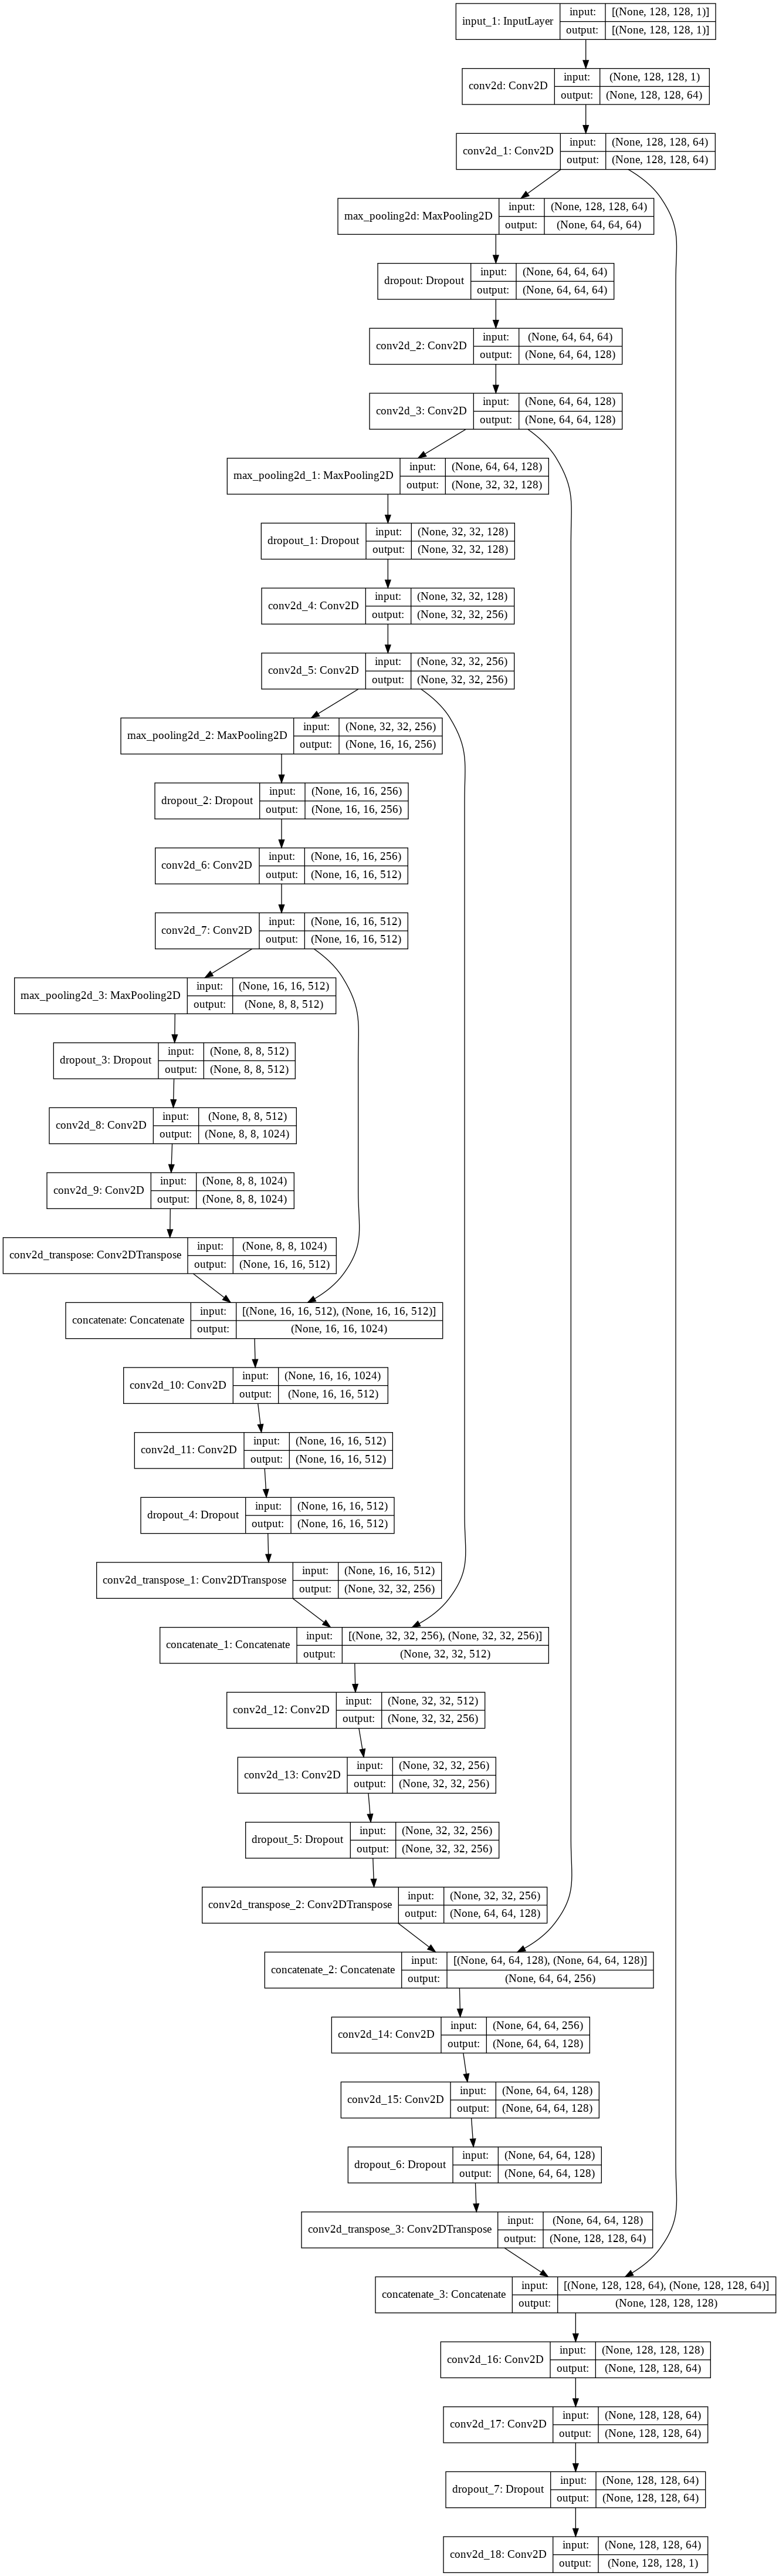

In [ ]:
#Contracting path
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

#Bottleneck layer
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

#Expanding layer
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

**The loss for evaluating the performance of model in semantic segmentation will be IoU (Intersection over Union). It is the ratio of intersection of pixels between predicted and target image over their union. The MeanIoU() method in tf.keras.metrics package can be used.**

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005))
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

**Model Training over 120 epochs**

In [ ]:
checkp = ModelCheckpoint('./cancer_image_model.h5', monitor = 'val_loss', save_best_only = True, verbose = 3)

In [ ]:
history = model.fit(X_train, y_train, epochs = 120, batch_size = 32, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/120
24/24 [==============================] - 19s 779ms/step - loss: 0.0623 - val_loss: 0.0663

Epoch 00001: val_loss improved from inf to 0.06635, saving model to ./cancer_image_model.h5
Epoch 2/120
24/24 [==============================] - 19s 777ms/step - loss: 0.0598 - val_loss: 0.0694

Epoch 00002: val_loss did not improve from 0.06635
Epoch 3/120
24/24 [==============================] - 19s 779ms/step - loss: 0.0559 - val_loss: 0.0677

Epoch 00003: val_loss did not improve from 0.06635
Epoch 4/120
24/24 [==============================] - 19s 779ms/step - loss: 0.0511 - val_loss: 0.0552

Epoch 00004: val_loss improved from 0.06635 to 0.05522, saving model to ./cancer_image_model.h5
Epoch 5/120
24/24 [==============================] - 19s 781ms/step - loss: 0.0494 - val_loss: 0.0496

Epoch 00005: val_loss improved from 0.05522 to 0.04961, saving model to ./cancer_image_model.h5
Epoch 6/120
24/24 [==============================] - 19s 779ms/step - loss: 0.0471 - val_loss: 0.05

**Model Performance**

Text(0.5, 1.0, 'Losses vs Epochs')

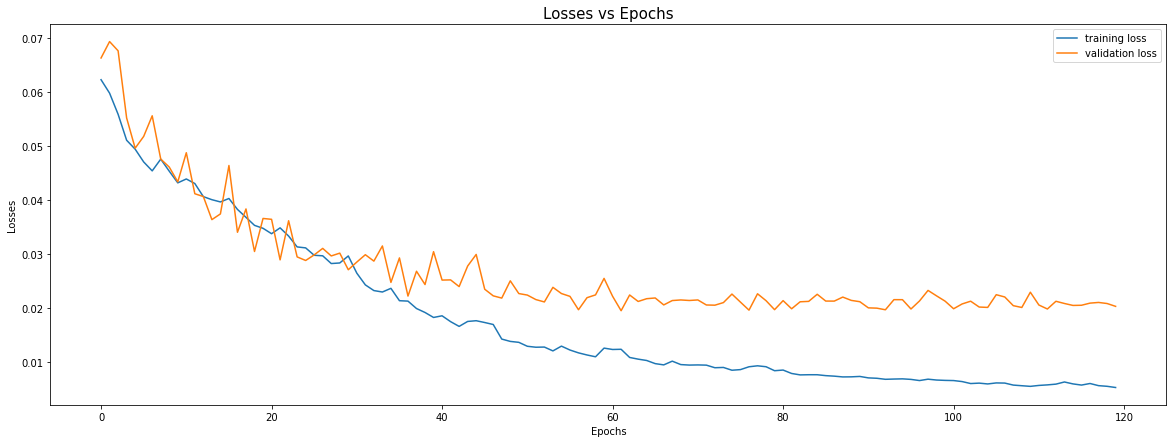

In [ ]:
plt.figure(figsize = (20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses vs Epochs', fontsize = 15)

In [ ]:
model.save(path+'//'+'segmented_model_breast_cancer.h5')

In [ ]:
from keras.models import load_model
model = load_model('./cancer_image_model.h5')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(y_pred.shape)

(39, 128, 128, 1)


**Predictions**

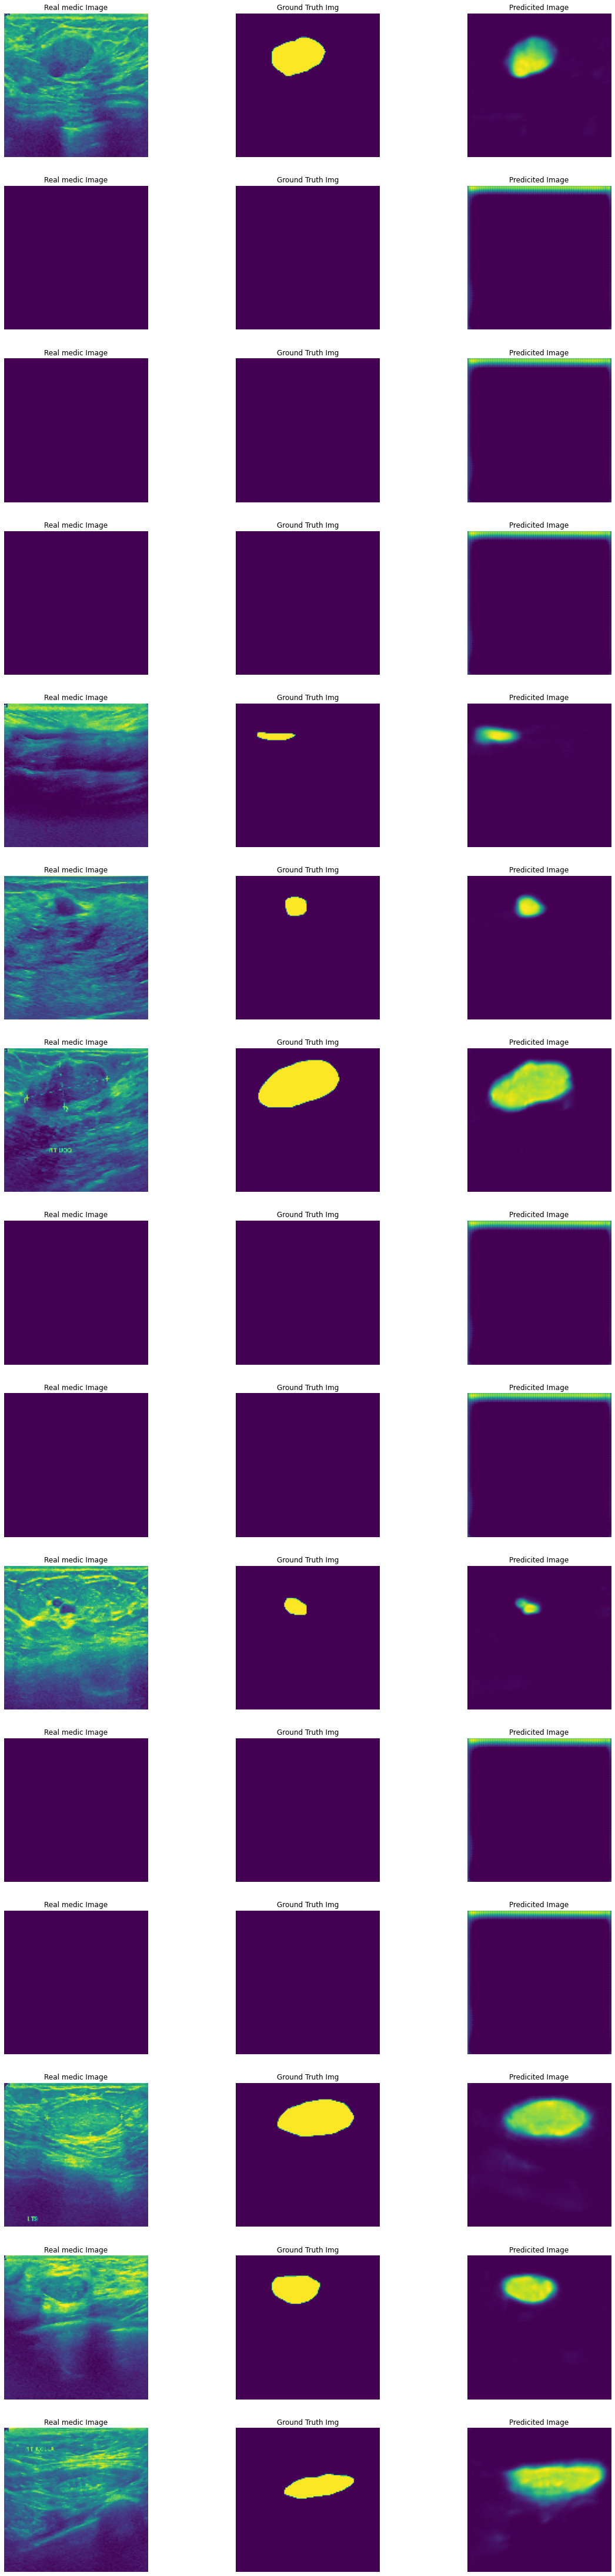

In [ ]:
plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(tf.squeeze(X_test[x]))
    plt.title('Real medic Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(tf.squeeze(y_test[x]))
    plt.title('Ground Truth Img')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(tf.squeeze(y_pred[x]))
    plt.title('Predicited Image')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()

**Model testing over single image**

In [ ]:
test = []
test.append(img_to_array(Image.fromarray(cv2.resize(cv2.imread( "/content/malignant (188).png" , cv2.IMREAD_GRAYSCALE), (128,128)))))

In [ ]:
testX = np.array(test[0])
testX=np.reshape(testX,[1,128,128,1])
testX/= 255.0
print(testX.shape)
print(f'Minimum : {testX.min()}')
print(f'Maximum : {testX.max()}')

(1, 128, 128, 1)
Minimum : 0.0
Maximum : 0.8823529481887817


(-0.5, 127.5, 127.5, -0.5)

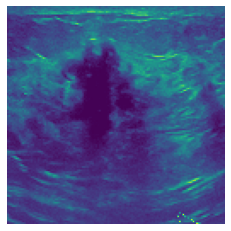

In [ ]:
plt.imshow(squeeze(testX))
plt.axis('off')

(1, 128, 128, 1)


(-0.5, 127.5, 127.5, -0.5)

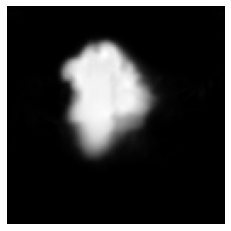

In [ ]:
#testX=np.reshape(X_test[0],[1,128,128,1])
predY = model.predict(testX)
print(predY.shape)
testX1=np.reshape(predY,[128,128])
plt.imshow(testX1, 'gray')
plt.axis('off')

**Define classes mapping for classification model**

In [14]:
info = [
    'bening'   ,  # 0
    'melingent'   ,  # 1
    'normal',  # 2
]

In [10]:
X = []
y = []

label_num = -1

for label_class in os.listdir(path) :
    
    new_path   = path + label_class
    label_num += 1
    
    for img in os.listdir(new_path) :
        if 'mask' not in img :
            
            y.append(label_num)
            x = cv2.imread(path + label_class +'/'+img, cv2.IMREAD_GRAYSCALE)
            X.append(img_to_array(Image.fromarray(cv2.resize(x, (128,128)))))

In [11]:
X = np.array(X)
y = np.array(y)
X/= 255.0
y = to_categorical(y)
print(X.shape)
print(y.shape)
print(X.min())
print(X.max())


(780, 128, 128, 1)
(780, 3)
0.0
1.0


(-0.5, 127.5, 127.5, -0.5)

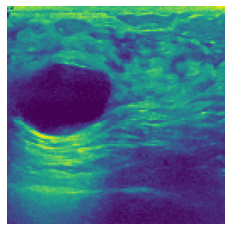

In [12]:
plt.imshow(squeeze(X[0]))
plt.axis('off')

0.0
1.2414118


(-0.5, 127.5, 127.5, -0.5)

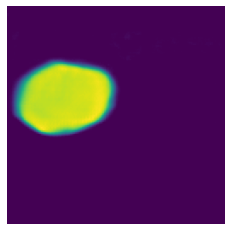

In [22]:
localize = load_model(path+'cancer_image_model.h5')

M = localize.predict(X)
print(M.min())
print(M.max())

plt.imshow(squeeze(M[0]))
plt.axis('off')

**train-test split for classification model**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size = 0.1, shuffle = True, random_state = 1)

In [24]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(702, 128, 128, 1)
(702, 3)
(78, 128, 128, 1)
(78, 3)


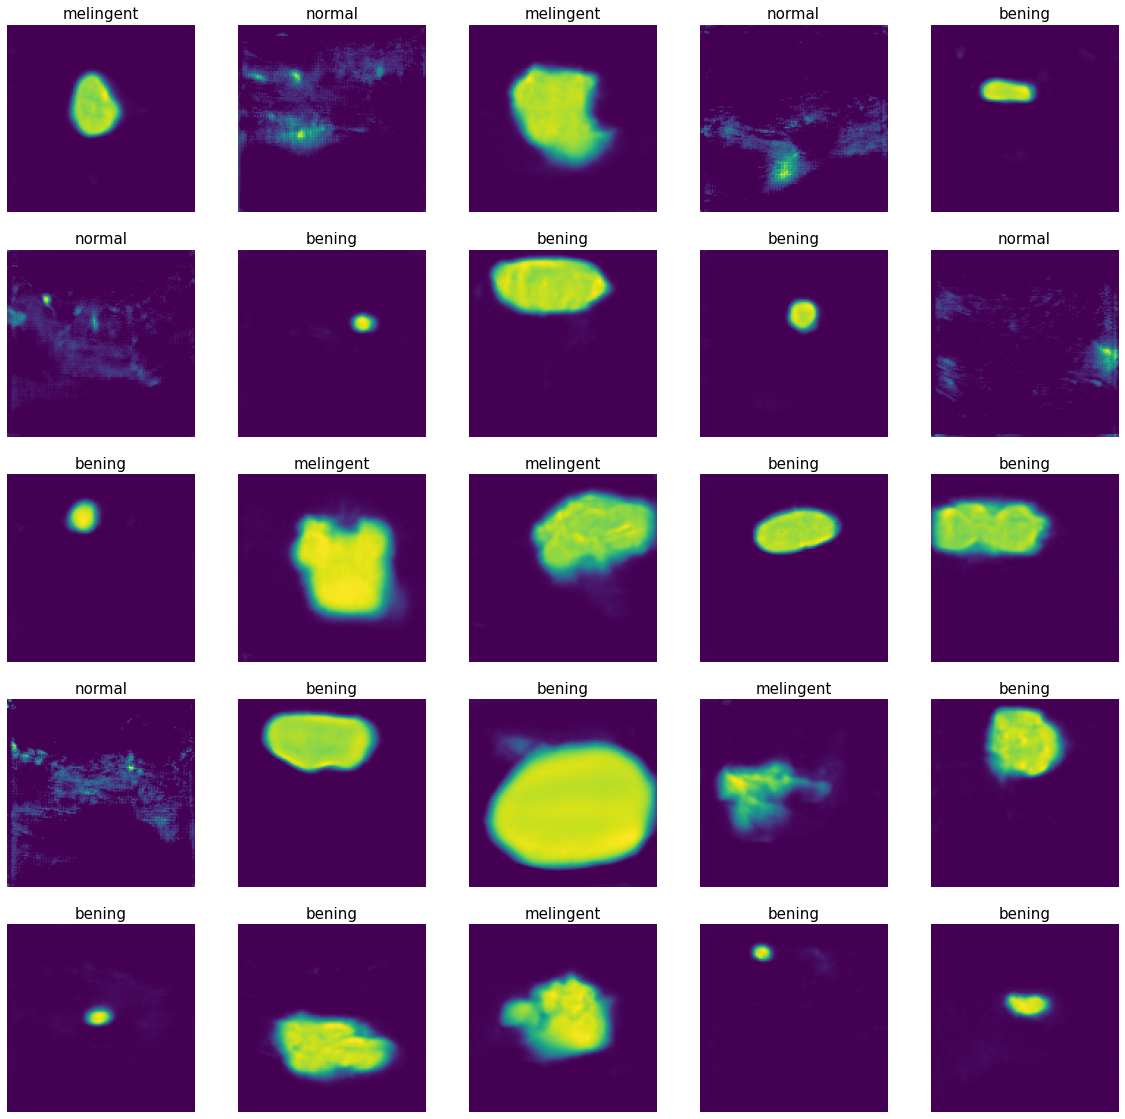

In [48]:

plt.figure(figsize = (20,20))
i = 0
SIZE = 702
while i < 25 :
    
    x = randint(0, SIZE)
    plt.subplot(5,5,i+1)
    plt.imshow(squeeze(X_train[x]))
    plt.title(f'{info[np.argmax(y_train[x])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

****
**Data augmentation**

In [50]:
train_gen = ImageDataGenerator(horizontal_flip = True, rotation_range = 15, width_shift_range = [-10, 10], height_shift_range = [-10, 10], zoom_range = [0.80, 1.00])
train_gen.fit(X_train)

In [51]:
pointer = train_gen.flow(X_train, y_train)
trainX, trainy = pointer.next()

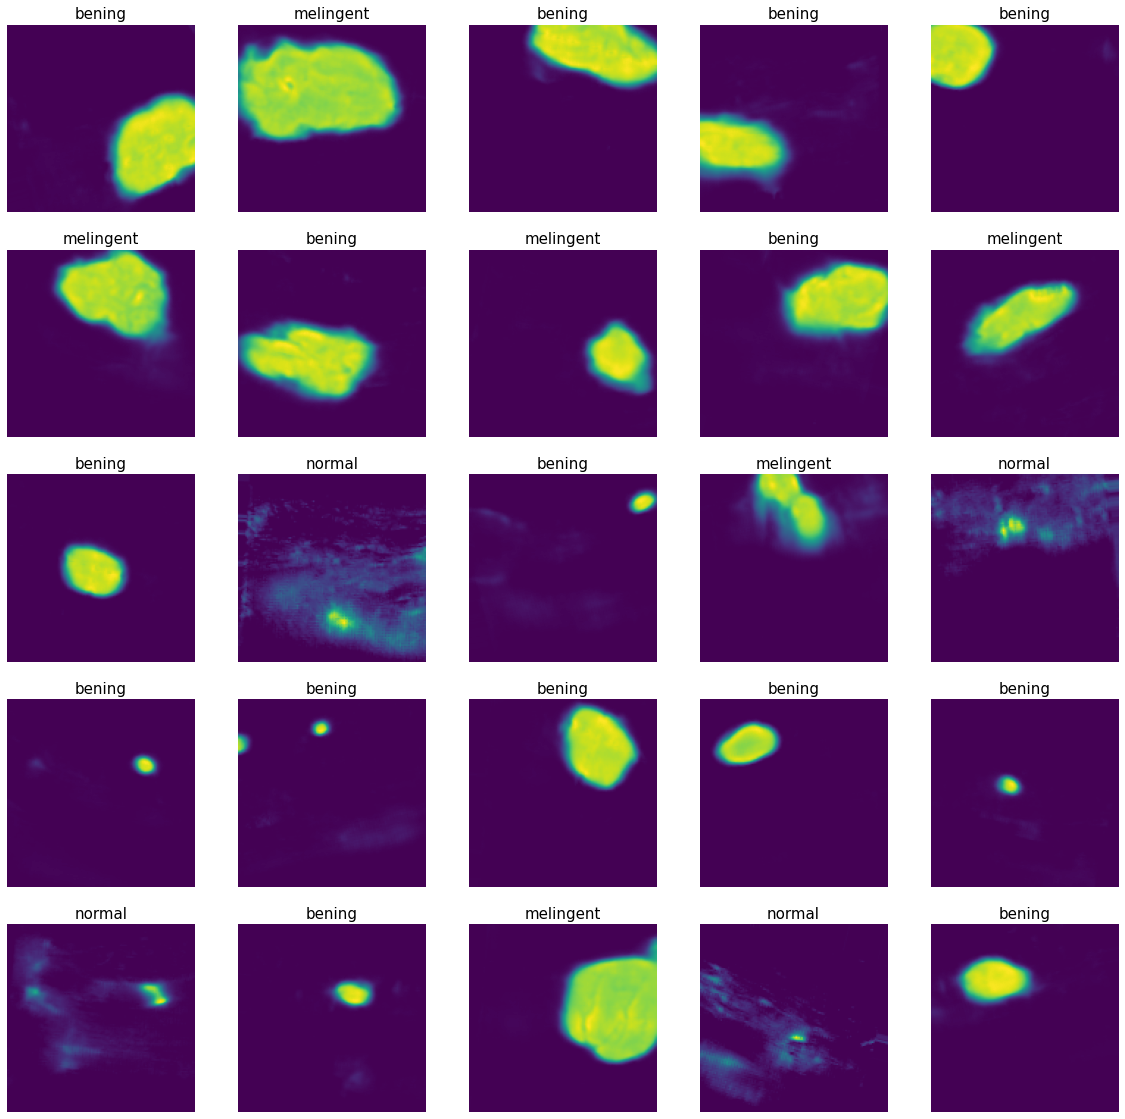

In [52]:
plt.figure(figsize = (20,20))

i = 0

while i < 25 :
    
    plt.subplot(5, 5, i+1)
    plt.imshow(squeeze(trainX[i]))
    plt.title(f'{info[np.argmax(trainy[i])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

**make CNN model for classifer**

In [54]:
def conv_block (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), strides = 1, padding = 'same', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    model.add(MaxPooling2D())
    
    return model

def dens_block (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    return model
def cnn (filter1, filter2, filter3, filter4, hidden1) :
    
    model = Sequential([
        
        Input((128,128,1,)),
        conv_block(filter1),
        conv_block(filter2),
        conv_block(filter3),
        conv_block(filter4),
        Flatten(),
        dens_block(hidden1),
        Dense(3, activation = 'softmax')
    ])
    
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
    
    return model


In [55]:
model = cnn(32, 64, 128, 256, 32)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 32)        448       
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 64)        18752     
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 16, 128)       74368     
_________________________________________________________________
sequential_3 (Sequential)    (None, 8, 8, 256)         296192    
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 32)                524448    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

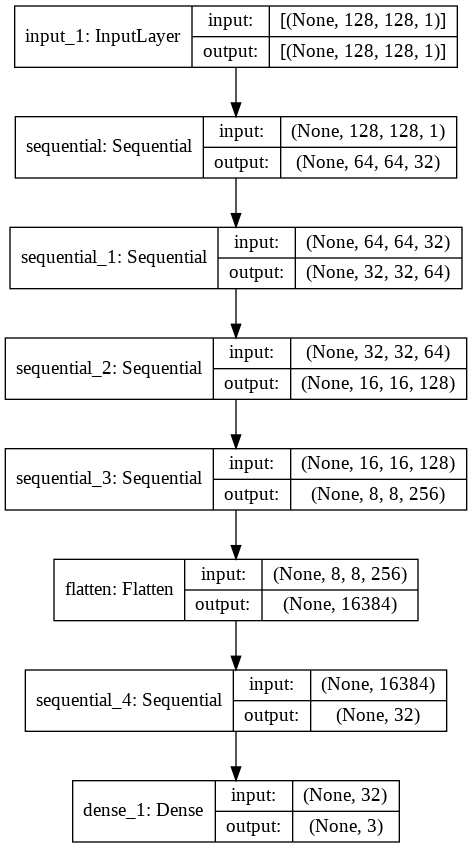

In [58]:
plot_model(model, 'cancer_classify.png', show_shapes = True)

In [59]:
checkp = ModelCheckpoint('./valid_classifier.h5', monitor = 'val_loss', save_best_only = True, verbose = 2)


In [60]:
history = model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 400, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/400
11/11 [==============================] - 5s 268ms/step - loss: 4.6493 - accuracy: 0.5256 - val_loss: 4.7355 - val_accuracy: 0.1667

Epoch 00001: val_loss improved from inf to 4.73546, saving model to ./valid_classifier.h5
Epoch 2/400
11/11 [==============================] - 2s 145ms/step - loss: 4.1348 - accuracy: 0.6880 - val_loss: 4.6133 - val_accuracy: 0.1667

Epoch 00002: val_loss improved from 4.73546 to 4.61328, saving model to ./valid_classifier.h5
Epoch 3/400
11/11 [==============================] - 2s 148ms/step - loss: 3.7928 - accuracy: 0.7336 - val_loss: 4.5274 - val_accuracy: 0.1667

Epoch 00003: val_loss improved from 4.61328 to 4.52738, saving model to ./valid_classifier.h5
Epoch 4/400
11/11 [==============================] - 2s 148ms/step - loss: 3.4728 - accuracy: 0.7621 - val_loss: 4.4700 - val_accuracy: 0.1667

Epoch 00004: val_loss improved from 4.52738 to 4.47003, saving model to ./valid_classifier.h5
Epoch 5/400
11/11 [==============================] -

In [62]:
model = keras.models.load_model('./valid_classifier.h5')
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = info))

Accuracy : 0.8717948717948718
              precision    recall  f1-score   support

      bening       0.94      0.81      0.87        42
   melingent       0.78      0.91      0.84        23
      normal       0.87      1.00      0.93        13

    accuracy                           0.87        78
   macro avg       0.86      0.91      0.88        78
weighted avg       0.88      0.87      0.87        78



Text(0.5, 145.31999999999996, 'Predicted')

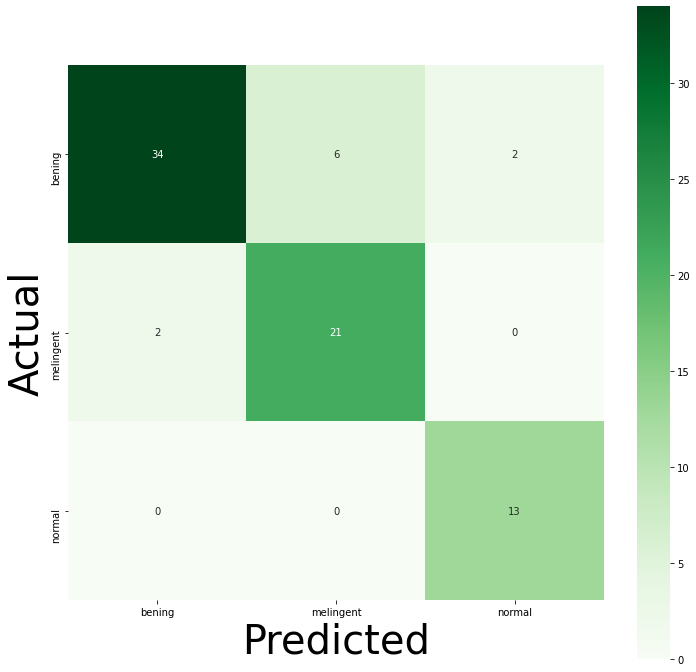

In [66]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (12,12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

*predict mask and label for both models**

In [7]:
classifier = load_model('./valid_classifier.h5')
localize = load_model('./cancer_image_model.h5')

In [32]:
image_path = [
    '/content/drive/My Drive/Colab Notebooks/Breast_cancer/Dataset_BUSI_with_GT/benign/benign (110).png',
    '/content/drive/My Drive/Colab Notebooks/Breast_cancer/Dataset_BUSI_with_GT/benign/benign (100).png',
    '/content/drive/My Drive/Colab Notebooks/Breast_cancer/Dataset_BUSI_with_GT/normal/normal (106).png'
]

In [36]:
testX = []
for img in image_path :
    testX.append(img_to_array(Image.fromarray(cv2.resize(cv2.imread(img, cv2.IMREAD_GRAYSCALE), (128,128)))))
testX = np.array(testX)
testX/= 255.0
predY = localize.predict(testX)
pred_label = classifier.predict(predY)

[0 0 2]
index 3 is out of bounds for axis 0 with size 3


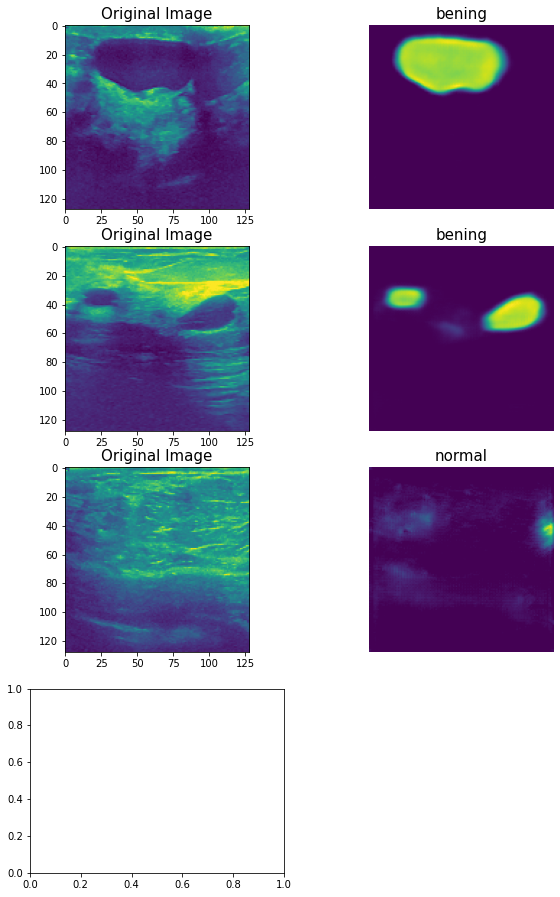

In [39]:
print(np.argmax(pred_label, axis = 1))
plt.figure(figsize = (10,40))

i = 0
j = 0
try:
    while i < 20 :
        
        plt.subplot(10,2,i+1)
        plt.imshow (squeeze(testX[j]))
        plt.title('Original Image', fontsize = 15)
        plt.axis('off')
        
        plt.subplot(10,2,i+2)
        plt.imshow (squeeze(predY[j]))
        plt.title(f'{info[np.argmax(pred_label[j])]}', fontsize = 15)
        plt.axis('off')
        
        j += 1
        i += 2
    plt.show()
except Exception as e:
  print(e)   